## Wine classification

Resource used:

https://www.kaggle.com/piyushgoyal443/red-wine-dataset



Curret project will use methods for wine quality estimatio based on input attributes. Method could help wine producers to predict their wine quality and based on this to target suitable price levels. 

Also suitable user consumer system could be created based on this algorithm to protect customers and help them choose suitable wines. For this purpose however, local wines should be taken as a samples and measured. This could help consumers with no good wine quality expereince to select best wines for the given price levels. 

Original study used SVM (lenear and Gausian) for this analysis. 
Additilnal algorithms that will be tested: Random Forest, Linear Regression (as a simples method).  

Grid search will be applied and algorithms will be assessed using f1_score and ROC curve.


In [190]:
#importing neccessary libraries

import numpy as np
import pandas as pd


#oprimization and scoring
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

#import metrics for model estimation
from sklearn.metrics import f1_score, make_scorer, roc_curve
from sklearn.preprocessing import StandardScaler

#plots (if neccessary)
import matplotlib.pyplot as plt
from nose.tools import *
import seaborn as sns

#models
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Suport vector machines 
from sklearn.svm import SVC
#needed to bootstrap. 
from sklearn.utils import resample
#for saving/loading the models. this will give option to precompute the models
from sklearn.externals import joblib

#will be used to check if models exists.
import os.path

#initiate the random state generator
np.random.seed(24680)


In [232]:
#variables:
LinearRegression_file = "LR_grid_search_object.pkl"
RandomForest_file = "RF_grid_search_object.pkl"
SVM_file = "SVM_grid_search_object.pkl"

### Process
	1. load data set
	2. cleaning and knowing data. It is very important to know what would be good for the algorithm, which are the good attributes.
	3. after bootstraping samples size is increased
    4. Split the data to attributes and labels
    5. Normalization
    6. Train/test data split
	Try different algorithms and super parameters tests.
    7. LigistiRegression
    8. RandomForest
    9. SVM
	10. Classification of metrics and assessment of algorithm precision. 
    11. final model study selection.

### 1. Load the file

In [233]:
#pandas read.csv 
data_set = pd.read_csv('winequalityN.csv')
#check if data is loaded propoerly and its dimentions. 
data_set.shape


(6497, 13)

### 2. Checking for null samples and cleaning them

In [234]:
print('Check if there is null values')
print(data_set.isnull().sum())
print('\nShape: '+str(data_set.shape)+'\n') 
#dropna removed rows with null values. Asiz = 0 means remove by rows
data_set = data_set.dropna(how='any', axis =0)

print("Clean nulls.")
#isnull check is there is null values. 
print(data_set.isnull().sum())
print('\nShape: '+str(data_set.shape)+'\n')

Check if there is null values
type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

Shape: (6497, 13)

Clean nulls.
type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Shape: (6463, 13)



Attributes definitions:
Description of attributes:

1 - fixed acidity: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2 - volatile acidity: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3 - citric acid: found in small quantities, citric acid can add 'freshness' and flavor to wines
4 - residual sugar: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5 - chlorides: the amount of salt in the wine
6 - free sulfur dioxide: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7 - total sulfur dioxide: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8 - density: the density of water is close to that of water depending on the percent alcohol and sugar content
9 - pH: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10 - sulphates: a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
11 - alcohol: the percent alcohol content of the wine

Output variable (based on sensory data): 12 - quality (score between 0 and 10)

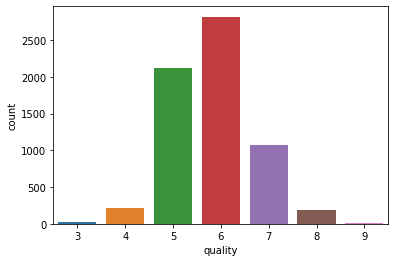

In [235]:
#Quality need to be recalculated to have good (1) and rest (0)
#study data. It looks like 7 is good value to split the quality in good and rest. Labes have normal distribution.
sns.countplot(data_set['quality'])

Samples size is small and the algorithm might not be trained properly. As a next step bootstrap will be used.

In [236]:
data_set.describe().T
#some of the features have different ranges and will need to be normalized in order that the classifiers work proporly. 

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6463.0,7.217755,1.297913,3.80000,6.40000,7.00000,7.700,15.90000
volatile acidity,6463.0,0.339589,0.164639,0.08000,0.23000,0.29000,0.400,1.58000
citric acid,6463.0,0.318758,0.145252,0.00000,0.25000,0.31000,0.390,1.66000
residual sugar,6463.0,5.443958,4.756852,0.60000,1.80000,3.00000,8.100,65.80000
chlorides,6463.0,0.056056,0.035076,0.00900,0.03800,0.04700,0.065,0.61100
free sulfur dioxide,6463.0,30.516865,17.758815,1.00000,17.00000,29.00000,41.000,289.00000
total sulfur dioxide,6463.0,115.694492,56.526736,6.00000,77.00000,118.00000,156.000,440.00000
density,6463.0,0.994698,0.003001,0.98711,0.99233,0.99489,0.997,1.03898
pH,6463.0,3.218332,0.160650,2.72000,3.11000,3.21000,3.320,4.01000
sulphates,6463.0,0.531150,0.148913,0.22000,0.43000,0.51000,0.600,2.00000


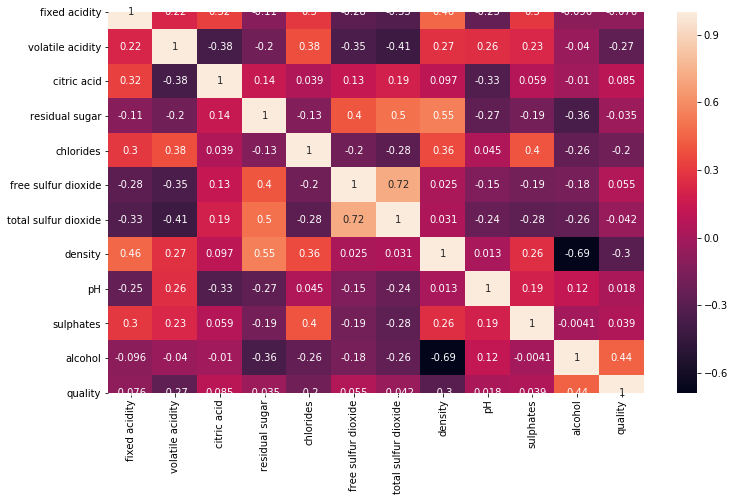

In [237]:
#print correlation between attributes.
plt.figure(figsize=(12, 7))
sns.heatmap(data_set.corr(), annot=True)
plt.show()

In [238]:
#based on the graph above, we could reduce the number of features without loosing too much information as
#the features are correlated. We will drop "free sulfur dioxide" and keep "total sulfur dioxide"
data_set = data_set.drop("free sulfur dioxide", axis=1)
#recalculate quality values. // will return 1 if the value is higher than 7 and smaller than 9 and 0 if value is smaller than 7
#according to the study the Quality is from 0 to 10. quality is recalculated and safed as new column called N_quality (new quality)
data_set['N_quality'] = data_set["quality"]//7
data_set = data_set.drop('quality', axis=1)


### 4. Split the  attributes and lables. Lable colum is N_quality. 

In [240]:
#used bootstraped data
wine_attributes = data_set.drop("N_quality", axis=1)
#change type (red/white) to value using get_dummy
wine_attributes = pd.get_dummies(wine_attributes)
#print(wine_attributes.describe())
wine_labels = data_set.N_quality


### 5. Normalization
In order that alrorithm to work accordingly we will check the ranges of the attributes and apply normalization.

In [241]:
scaler = StandardScaler()
#get columns names
col_names = list(wine_attributes.columns.values)
#transform 
scaled_features = scaler.fit_transform(wine_attributes)
#cobine array and list in dataframe using the original names
wine_attributes = pd.DataFrame(scaled_features, columns = col_names)


### 6. Split the data in train /test sets
will be done with predefined function in sklearn. Data is split in 80/20.

In [242]:
wine_attributes_train, wine_attributes_test, wine_labels_train, wine_labels_test = train_test_split (wine_attributes, wine_labels, train_size = 0.8, stratify = wine_labels)
#check that data was split properly
wine_attributes_train.shape

(16000, 12)

### 3. As the data size is small (around 6k smaples), we will apply bootstrap to incease the number of samples.

Sample size will be increased to 20K by resampling


In [239]:
#resample is creating n_samepls based on the origianl data set. Data will be scrambled
wine_attributes_train = resample(wine_attributes_train, n_samples=20000, replace=True, stratify=data_set, random_state=np.random.randint(0,7000))
data_set.shape

(20000, 12)

### Prepare the cross-validation folds

In [243]:
#prepare k_folds for grid search. Same split for the models will be used for fair comarision of the models. 
#Data will be split in 4 folds
k_fold = StratifiedKFold (n_splits = 5)
#preparint the split
k_fold.split(wine_attributes_train, wine_labels_train)

<generator object _BaseKFold.split at 0x014E4F70>

### 7. Train Logistic regression

Fine-tune the C and max_iter and fit_intercept parameters.

    "C": [0.0001, 0.01, 0.1, 1, 10, 100, 10000],
    "max_iter": [100, 300, 1000],
    "fit_intercept": [True, False]

In [244]:
#define super parameter values to be tested with grid search
params = {
    "C": [0.0001, 0.01, 0.1, 1, 10, 100, 10000],
    "max_iter": [50, 100, 300, 1000],
    "fit_intercept": [True, False]
}
#check if model is already precomputed - will save time during the exam. 
if(not os.path.isfile(LinearRegression_file)):
    print('computing model')
    #grid seach with f1 score and cross validation, using Logistic Regretion
    grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=params, scoring=make_scorer(f1_score), cv= k_fold)
    #fit the model with train data
    grid_search.fit(wine_attributes_train, wine_labels_train)
    LR_train_score = grid_search.best_score_
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    #https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
    #save the object to external file with joblib.
    joblib.dump(grid_search, LinearRegression_file)
    #joblib.load(filename)
else:
    print("Model exists.")


Model exists.


### 8. Train Random forest algorithm

Test parameters:

    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "n_estimators": [100, 200, 500]

In [245]:
#parameter to test with grid search
tuned_params = {
    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "n_estimators": [100, 200, 500]
}
#check if model is already precomputed - will save time during the exam. 
if(not os.path.isfile(RandomForest_file)):
    print("Computing model")
    #grid seach with f1 score and cross validation, using Logistic Regretion
    grid_search = GridSearchCV (estimator=RandomForestClassifier(), param_grid=tuned_params, scoring=make_scorer(f1_score), cv= k_fold)
    #fit/train the model with train data
    grid_search.fit(wine_attributes_train , wine_labels_train)
    print(grid_search.best_estimator_)
    RF_train_score = grid_search.best_score_
    print(grid_search.best_score_)
    #save the model to file
    joblib.dump(grid_search, RandomForest_file)
else:
    print("Model exist.")


Model exist.


### 9. Train SVM

Test parameters:

'C': [10, 15, 20, 50, 200],  
'gamma': [0.1, 0.01, 0.001, 0.0001],
'kernel': ['rbf']

In [246]:
#parameters to test with linear SVM
tuned_params = {
            'C': [10, 15, 20, 50, 200],  
            'gamma': [0.1, 0.01, 0.001, 0.0001], 
            'kernel': ['rbf']
}
#check if model is already precomputed - will save time during the exam. 
if(not os.path.isfile(SVM_file)): 
    print("Compuning model")
    #grid seach with f1 score and cross validation, using Logistic Regretion
    grid_search = GridSearchCV (estimator=SVC(tol=1, max_iter=10000, probability=True), param_grid=tuned_params, scoring=make_scorer(f1_score), cv= k_fold)
    #fit/train the model with train data
    grid_search.fit(wine_attributes_train , wine_labels_train)
    #save the model to file
    joblib.dump(grid_search, SVM_file)
    print(grid_search.best_estimator_)
    SVM_train_score = grid_search.best_score_
    print(grid_search.best_score_)
else:
    print("Model exists.")

Model exists.


### 10. Estimate the models precision.

#### Logistic regression

In [247]:
#load LR model from file and make F1 score
LR_loaded_model = joblib.load(LinearRegression_file)
#predict based on test data set
prediction_LR = LR_loaded_model.predict(wine_attributes_test)
LR_wine_score = f1_score(wine_labels_test, prediction_LR)

print("Linear Regression F1 score:", LR_wine_score)
print("Linear Regression train score", LR_loaded_model.best_score_)
print(LR_loaded_model.best_estimator_)

Linear Regression F1 score: 0.5178979436405179
Linear Regression train score 0.5035078293402887
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


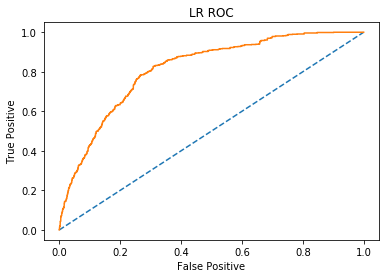

In [248]:
# predict probabilities
probs = LR_loaded_model.predict_proba(wine_attributes_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(wine_labels_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)

# Add title and axis names
plt.title('LR ROC')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
# show the plot
plt.show()

####  Random Forest

In [250]:
#load LR model from file and make F1 score
RF_loaded_model = joblib.load(RandomForest_file)
#predict based on test data set
prediction_RF = RF_loaded_model.predict(wine_attributes_test)
RF_wine_score = f1_score(wine_labels_test, prediction_RF)
print("Random forest test F1 score:", RF_wine_score)
print("Random forest train score", RF_loaded_model.best_score_ )
print(RF_loaded_model.best_estimator_)

Random forest test F1 score: 0.9968294229549778
Random forest train score 0.9600085393855994
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


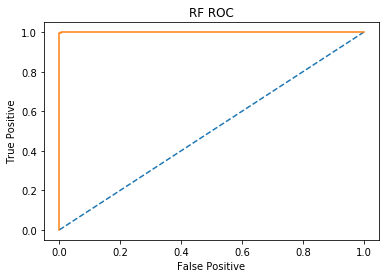

In [251]:
# predict probabilities
probs = RF_loaded_model.predict_proba(wine_attributes_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(wine_labels_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# Add title and axis names
plt.title('RF ROC')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
# show the plot
plt.show()

#### SVM

In [252]:
#load SVM model from file and make F1 score
SVM_loaded_model = joblib.load(SVM_file)
#predict based on test data set
prediction_SVM = SVM_loaded_model.predict(wine_attributes_test)
SVM_wine_score = f1_score(wine_labels_test, prediction_SVM)
print("SVM test F1 score:", SVM_wine_score)
print("SVM training score:", SVM_loaded_model.best_score_)
print(SVM_loaded_model.best_estimator_)

SVM test F1 score: 0.7467330429371499
SVM training score: 0.7033427481344049
SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=10000, probability=True, random_state=None, shrinking=True, tol=1,
    verbose=False)


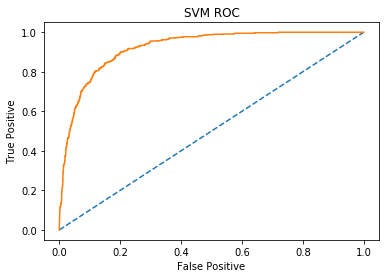

In [211]:
# predict probabilities
probs = SVM_loaded_model.predict_proba(wine_attributes_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(wine_labels_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# Add title and axis names
plt.title('SVM ROC')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
# show the plot
plt.show()

### 11. Conclusion
Based on the results of F1 score and ROC plots, random forest algorithm gives the best result but the model seems to overfit. Project is not perfect as the data set has only 6K samples and even search grid and bootstrap seems not enough.  
Prject was tested without boostrap - LR F1 score 0.50 vs 0.51, RF F1 score 0.63 vs 0.996, SVM F1 score 0.74 vs 0.74. Magrnal or no improvement of Linear Regression and SVM and good improvement in Random forest. 
Different parameters were tested (this is maybe the 10th set that was tried) for Random forest but once the data was increased with boostrap the algorithm is giving similar high results.